# Search for missing RBs in non trace suppressed data with the track trigger

* e.g. Run 118 (without trace suppression) is suitable for such a study
* Run 120 has central track trigger and trace suppression
* Also plot the baselines

In [1]:
import gaps_online.tof as gt
import gaps_online as go
import gaps_tof as gt_cxx
import gaps_online.db as db
import rust_dataclasses as rd
import re
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path
#import HErmes.fitting as fit

import dashi as d
import pylab as p
import numpy as np
d.visual()
import charmingbeauty.visual as vis
import charmingbeauty.layout as lo
vis.set_style_present()

# FIXME add DJANGO_ALLOW_ASYNC_UNSAFE=1 to setup.env
RUNPATH  = Path('/data1/nextcloud/cra_data/data/2023_nevis/tof/')
CALIPATH = RUNPATH / 'calibration'

In [2]:
def rms(data):
    return np.sqrt((1/len(data))*((data**2).sum()))

In [3]:
paddles = db.tof_paddle_manifest()
rbs     = db.tdb.models.RB.objects.all()
pends   = db.tdb.models.PaddleEnd.objects.all()

In [4]:
pattern = re.compile('RB(?P<rbid>[0-9]*)_')

calibrations = CALIPATH.glob('*.tof.gaps')
calib = dict()

for fname in calibrations:
    fname = str(fname)
    rbid = int(pattern.search(fname).groupdict()['rbid'])
    calib[rbid] = go.cxx_api.RBCalibration.from_califile(fname)

[2024-02-29 02:48:18.375] [info] [io.cxx:92] Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:18] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:19] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:19] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:19] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:20] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:20] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:20] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:21] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:21] -- Read out 1 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-2

In [7]:
print (calib[1])

<ReadoutboardCalibration:
	 RB             : 1
	 VCalData       : 1000 (events)
	 TCalData       : 1000 (events)
	 NoInputData    : 1000 (events)
	 V Offsets [ch0]: .. 4533.201172 4792.408203..
	 V Incrmts [ch0]: .. 0.063705 0.063763..
	 V Dips    [ch0]: .. 6.364990 6.589600..
	 T Bins    [ch0]: .. 0.404588 0.567620..>


## Run 120 - central track trigger, trace suppression

In [5]:
runfiles = (RUNPATH / '120').glob('*.tof.gaps')
nfiles = 0
events = []
for rfile in runfiles:
    packets = gt.get_tofpackets(str(rfile), filter=go.cxx_api.PacketType.TofEvent)
    events.extend([go.cxx_api.TofEvent.from_tofpacket(k) for k in packets])
    nfiles += 1
    if nfiles == 20:
        break

[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1288 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1196 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1271 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1304 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1278 packets from bytestream!
[error] [events.cxx - from_bytestream:828] [2024-02-29 02:48:31] -- Size matches neither 20 nor 25 LTBs!
[error] [events.cxx - from_bytestream:214] [2024-02-29 02:48:31] -- Tail signature incorrect! Got tail 62993
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1288 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 820 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 02:48:31] -- Read out 1312 packets from

In [6]:
all_missing_rbs = dict()

less_rbs = 0
more_rbs = 0
for ev in tqdm(events, desc='looking for HG/LG discrepancy...'):
    npaddle = ev.mt_event.n_paddles
    if len(ev.rbevents) != npaddle:
        try:
            hits = ev.mt_event.get_dsi_j_ch()
        except:
            continue
        
        for hit in hits:
            rbhit = db.get_HG_for_LG(*hit)[0]
            if not (rbhit in ev.get_rbids()):
                if not (rbhit in all_missing_rbs):
                    all_missing_rbs[rbhit] = 0
                all_missing_rbs[rbhit] += 1
        if npaddle > len(ev.rbevents):
            less_rbs += 1
        else:
            more_rbs += 1
print(f'\n -- less RB {less_rbs/len(events):1.2f} more RB {more_rbs/len(events):1.2f}, events {len(events)}')
print (all_missing_rbs)

looking for HG/LG discrepancy...:   0%|          | 0/2000 [00:00<?, ?it/s]


 -- less RB 0.03 more RB 0.00, events 25229
{39: 56, 42: 46, 27: 63, 18: 51, 1: 30, 22: 46, 23: 53, 21: 19, 14: 85, 44: 77, 36: 25, 24: 51, 16: 95, 9: 38, 29: 25, 40: 50, 19: 42, 30: 49, 2: 22, 17: 45, 13: 57, 41: 26, 33: 46, 34: 21, 7: 39, 4: 24, 20: 37, 8: 14, 25: 94, 46: 65, 3: 19, 32: 92, 5: 30, 11: 25, 31: 32, 26: 40, 28: 36, 6: 40, 15: 13, 35: 9}


In [10]:
print (len([k for k in all_missing_rbs]))

40


In [50]:
db.get_HG_for_LG(*ev.mt_event.get_dsi_j_ch()[0])
#ev.mt_event.get_dsi_j_ch()

(14, 1)

# Summary

We saw that the missing RBs are equally distributed across board ids, both for runs with and without trace suppression.

## Run 118 - no trace suppression

In [8]:
runfiles = (RUNPATH / '118').glob('*.tof.gaps')
nfiles = 0
events = []
for rfile in runfiles:
    packets = gt.get_tofpackets(str(rfile), filter=go.cxx_api.PacketType.TofEvent)
    events.extend([go.cxx_api.TofEvent.from_tofpacket(k) for k in packets])
    nfiles += 1
    if nfiles == 10:
        break

[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:57:40] -- Read out 1564 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:57:46] -- Read out 1563 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:57:50] -- Read out 1543 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:57:55] -- Read out 1539 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:57:59] -- Read out 1552 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:58:03] -- Read out 1516 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:58:08] -- Read out 1542 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:58:14] -- Read out 1530 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:58:19] -- Read out 1559 packets from bytestream!
[info] [io.cxx - get_tofpackets:92] [2024-02-29 00:58:24] -- Read out 1555 packets from bytestream!


In [9]:
ev = events[0]
all_rbs = dict()
all_ev = len(events)
ev_with_missing = 0
for rbid in ev.get_rbids(): 
    all_rbs[rbid] = 0
for ev in events:
    for rbid in ev.get_rbids():
        all_rbs[rbid] += 1
    if len(ev.get_rbids()) != 40:
        ev_with_missing += 1
print (f'-- in total {all_ev} events..')
print (f'-- {ev_with_missing/all_ev:1.4f} with at least 1 RB missing')
print ('-- RBID --> NEvents(RB) -- -- --')
for k in sorted(all_rbs):
    print (f'-- {k:02} --> {all_rbs[k]} [{(all_ev - all_rbs[k])/all_ev:1.4f}%]')


-- in total 15463 events..
-- 0.0647 with at least 1 RB missing
-- RBID --> NEvents(RB) -- -- --
-- 01 --> 15447 [0.0010%]
-- 02 --> 15436 [0.0017%]
-- 03 --> 15441 [0.0014%]
-- 04 --> 15448 [0.0010%]
-- 05 --> 15426 [0.0024%]
-- 06 --> 15431 [0.0021%]
-- 07 --> 15434 [0.0019%]
-- 08 --> 15447 [0.0010%]
-- 09 --> 15439 [0.0016%]
-- 11 --> 15436 [0.0017%]
-- 13 --> 15429 [0.0022%]
-- 14 --> 15438 [0.0016%]
-- 15 --> 15443 [0.0013%]
-- 16 --> 15436 [0.0017%]
-- 17 --> 15431 [0.0021%]
-- 18 --> 15436 [0.0017%]
-- 19 --> 15434 [0.0019%]
-- 20 --> 15437 [0.0017%]
-- 21 --> 15440 [0.0015%]
-- 22 --> 15430 [0.0021%]
-- 23 --> 15439 [0.0016%]
-- 24 --> 15433 [0.0019%]
-- 25 --> 15434 [0.0019%]
-- 26 --> 15436 [0.0017%]
-- 27 --> 15432 [0.0020%]
-- 28 --> 15431 [0.0021%]
-- 29 --> 15435 [0.0018%]
-- 30 --> 15442 [0.0014%]
-- 31 --> 15432 [0.0020%]
-- 32 --> 15438 [0.0016%]
-- 33 --> 15441 [0.0014%]
-- 34 --> 15436 [0.0017%]
-- 35 --> 15433 [0.0019%]
-- 36 --> 15437 [0.0017%]
-- 39 --> 15430 [0.

In [19]:
baselines = dict()
for k in rbs:
    baselines[k.rb_id] = dict()
    for ch in range(0,9):
        baselines[k.rb_id][ch] = []
        
for ev in tqdm(events, desc='Calculating baselines...'):
    for rbid in ev.get_rbids():
        if rbid == 0:
            continue
        rbev  = ev.get_rbevent(rbid)
        volts = calib[rbid].voltages(rbev)
        for ch in rbev.header.get_channels():
            bl = volts[ch][10:50].mean()
            baselines[rbid][ch].append(bl)

for k in baselines:
    for ch in baselines[k]:
        baselines[k][ch] = np.array(baselines[k][ch])
#print (baselines)   

Calculating baselines...:   0%|          | 0/15463 [00:00<?, ?it/s]

In [40]:
baseline_rms = dict()
all_baseline_rms = []
for k in rbs:
    baseline_rms[k.rb_id] = dict()
    for ch in range(0,8):
        baseline_rms[k.rb_id][ch] = rms(baselines[k.rb_id][ch])
        all_baseline_rms.append(rms(baselines[k.rb_id][ch]))
for k in baseline_rms:
    print (f'{k} - {baseline_rms[k]}')

1 - {0: 0.7075236072725974, 1: 31.28857119846819, 2: 31.349431959520913, 3: 31.41107030341385, 4: 31.470942328507032, 5: 54.538914274074614, 6: 63.003621598788634, 7: 104.4276927118198}
2 - {0: 0.7723130814828623, 1: 30.875065898250337, 2: 30.922870051145832, 3: 31.02667102009611, 4: 31.08525504333358, 5: 53.84415284932205, 6: 62.22617132710784, 7: 102.92956807164495}
3 - {0: 0.6041504059992857, 1: 0.5742837628041001, 2: 0.5476927542422951, 3: 0.5229047759099038, 4: 0.5149754465421966, 5: 44.57502485851502, 6: 54.568278700607074, 7: 77.18495823245632}
4 - {0: 0.8417808663574295, 1: 0.8453883196638576, 2: 31.218620703229636, 3: 44.19886442861254, 4: 62.45144151981314, 5: 70.00223788684355, 6: 76.64800131539467, 7: 93.76319655092247}
5 - {0: 0.8333224699068267, 1: 0.8312463230876275, 2: 0.797184271791669, 3: 31.437397018278148, 4: 31.477734820764805, 5: 54.66940350417351, 6: 77.31453385411915, 7: 99.7071714126737}
6 - {0: 0.7618684512137455, 1: 31.15622447240718, 2: 44.16465794287553, 3:

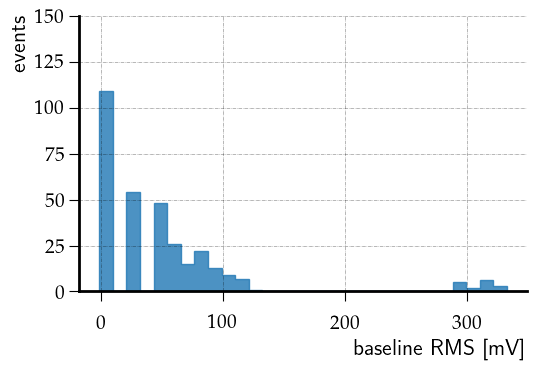

In [39]:
%matplotlib inline
rms_bins = np.linspace(0,50,40)
rms_bins = 30
#print (baseline_rms)
fig = p.figure(figsize=lo.FIGSIZE_A4_LANDSCAPE)
ax  = fig.gca()
ax.set_ylim(bottom=0, top=150)
ax.set_xlabel('baseline RMS [mV]', loc='right')
ax.set_ylabel('events', loc='top')
ax.set_yscale('linear')
h = d.histfactory.hist1d(all_baseline_rms,rms_bins)
h.line(alpha=0.8,filled=True)
p.show()

In [ ]:
%matplotlib inline
bl_bins = np.linspace(-3,3,30)
figsize = lo.FIGSIZE_A4[0]*10, lo.FIGSIZE_A4[1]*10
figsize = lo.FIGSIZE_A4
#fig = p.figure(figsize=lo.FIGSIZE_A4_LANDSCAPE)

for rbid in tqdm(baselines, desc='Creating distributions...'):
    fig, axes = p.subplots(nrows=8,
                           ncols=1,
                           sharex=True,
                           sharey=False,
                           figsize=figsize)
    axes = axes.flatten(order='F')
    idx = 0
    for ch in baselines[rbid]:
        if ch == 8:
            continue
        ax = axes[idx]
        p.sca(ax)
        data = baselines[rbid][ch]
        ax.text(-2.9,100,f'RB/CH {rbid}/{ch+1}\nNEVTS {len(data)}', fontsize=8)
        #ax.set_ylim(bottom=0.1)
        #ax.set_ylim(bottom=min(data))
        ax.set_yscale('symlog')
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        h   = d.factory.hist1d(data, bl_bins)
        h.line(filled=True, alpha=0.8)
        ax.text(0.8,0.05, 'baseline [mV]',transform=p.gcf().transFigure)
        ax.text(0.015,0.8, 'nevents',transform=p.gcf().transFigure, rotation=90)
        
        idx += 1
        #pass

    fig.subplots_adjust(hspace=0)
    fig.savefig(f'plots/baselines_rb{rbid}.png')
    #break
#p.show()
  

In [ ]:
      
data    = baselines[1][1]

ax  = fig.gca()
ax.set_yscale('symlog')
ax.set_xlabel('baseline bin[10:50] [mV]', loc='right')
ax.set_ylabel('nevents', loc='top')
ax.text(-2.9,max(data)*0.9,'RB/CH 1-1')
h   = d.factory.hist1d(data, bl_bins)
h.line(filled=True, alpha=0.8)
p.show()